In [39]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd

from sklearn.preprocessing import scale
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

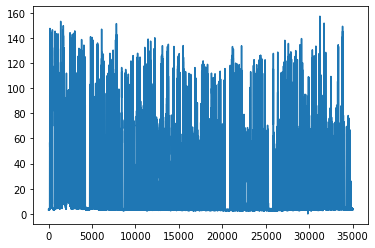

0        3.17
1        4.00
2        3.24
3        3.31
4        3.82
         ... 
35035    3.85
35036    3.74
35037    3.78
35038    3.78
35039    3.67
Name: Usage_kWh, Length: 35040, dtype: float64

In [2]:
df = pd.read_csv('Steel_industry_data.csv')
load = df['Usage_kWh']
time = np.array(df['date'])

plt.plot(load)
plt.show()
display(load)

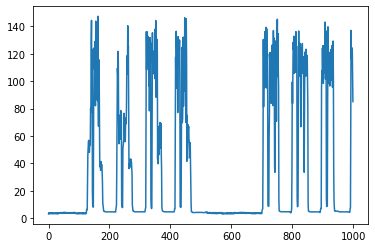

In [3]:
train = load[:1000]
test = load[1000:1300]
plt.plot(train)
plt.show()

In [38]:
# from sklearn.preprocessing import StandardScaler
# StdS_X = StandardScaler()
# StdS_y = StandardScaler()
# preprocess_train = StdS_X.fit_transform(np.array(train).reshape(-1,1))
# preprocess_test = StdS_y.fit_transform(y_p)

In [30]:

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,6):
    df_train["lag{}".format(i)] = df_train["Usage_kWh"].shift(i)
    df_test["lag{}".format(i)] = df_test["Usage_kWh"].shift(i)
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)
display(df_train, df_test)

,Usage_kWh,lag1,lag2,lag3,lag4,lag5
0,3.17,0.00,0.00,0.00,0.00,0.00
1,4.00,3.17,0.00,0.00,0.00,0.00
2,3.24,4.00,3.17,0.00,0.00,0.00
3,3.31,3.24,4.00,3.17,0.00,0.00
4,3.82,3.31,3.24,4.00,3.17,0.00
...,...,...,...,...,...,...
995,124.63,116.28,137.09,71.82,7.38,7.16
996,121.90,124.63,116.28,137.09,71.82,7.38
997,123.08,121.90,124.63,116.28,137.09,71.82
998,102.60,123.08,121.90,124.63,116.28,137.09


,Usage_kWh,lag1,lag2,lag3,lag4,lag5
1000,73.51,0.00,0.00,0.00,0.00,0.00
1001,107.75,73.51,0.00,0.00,0.00,0.00
1002,115.74,107.75,73.51,0.00,0.00,0.00
1003,92.09,115.74,107.75,73.51,0.00,0.00
1004,68.62,92.09,115.74,107.75,73.51,0.00
...,...,...,...,...,...,...
1295,8.64,13.97,12.96,13.28,14.00,15.55
1296,4.57,8.64,13.97,12.96,13.28,14.00
1297,5.11,4.57,8.64,13.97,12.96,13.28
1298,4.43,5.11,4.57,8.64,13.97,12.96


In [5]:
from statsmodels.tsa.arima.model import ARIMA
 
# Build Model
model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Usage_kWh   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4370.895
Date:                Mon, 18 Apr 2022   AIC                           8751.790
Time:                        20:01:31   BIC                           8776.323
Sample:                             0   HQIC                          8761.115
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5145      0.048    -31.363      0.000      -1.609      -1.420
ar.L2         -0.7522      0.051    -14.615      0.000      -0.853      -0.651
ma.L1          1.3865      0.060     23.242      0.0

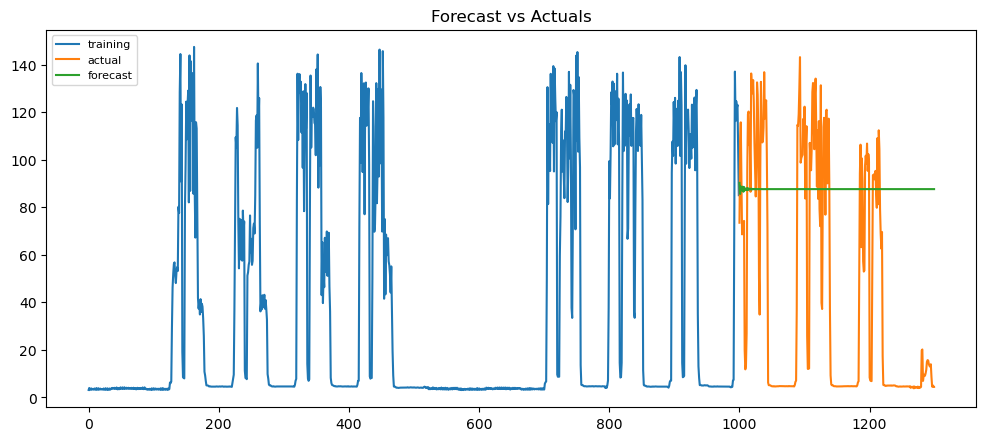

In [6]:
fc = fitted.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf', C= 0.5, gamma= 'scale')
regressor.fit(df_train, fitted.resid)

SVR(C=0.5)

In [44]:
param_grid = [
    {'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.0001, 0.001],
    'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVR(),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 0)
optimal_params.fit(df_train, fitted.resid)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.5, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ....................C=0.5, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.5, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.5, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.5, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred


[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.5, 1, 10, 100],
                          'gamma': ['scale', 1, 0.1, 0.01, 0.0001, 0.001],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=2)

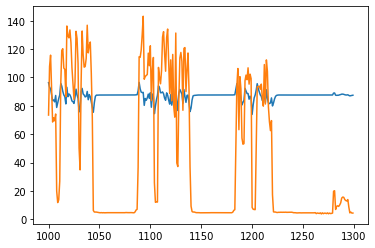

In [49]:
A=regressor.predict(np.array(df_test))
# print(A)
plt.plot(A+fc)
plt.plot(test)

In [ ]:
plt.plot((fitted.resid))

In [ ]:
a = scale(df_train)
display(pd.DataFrame(a))

In [11]:
display(fitted.resid)

0       3.170000
1       0.830189
2      -0.632871
3      -0.069101
4       0.511004
         ...    
995     1.206293
996     1.116526
997     1.049926
998   -22.876200
999   -16.544452
Length: 1000, dtype: float64

In [45]:
print(optimal_params.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
